# Import Functions 

In [1]:
from collections import defaultdict
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions import Normal
from torchvision.transforms import ToTensor
from functools import reduce
from typing import *
import numpy as np
import os
import pandas as pd


import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

In [2]:
# import nbimporter
from generating_synthetic_data import generate_3Z_synthetic_data
from generating_synthetic_data import ReparameterizedDiagonalGaussian
from generating_synthetic_data import plot_latent_2d, plot_y_dist, p

from base_VAE import VariationalInference, run_training

# Generate Data 

In [3]:
E=[0.2, 2, 3, 5] # environmental factors
envs, Xs, train_loader, test_loader = generate_3Z_synthetic_data(E)
X = Xs[0] # call first X for testing

# Neural Network to Reconstruct X using 1 channel


## Model

In [4]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # q_phi(z|x) = N(z | mu(x), sigma(x)),
        # mu(x),
        # log(sigma(x)) = h_phi(x)`
        
        # Step 1:
        # Define input dimensions -> self.input_shape
        # Step 2:
        # Define the rest of the encoding architecture
        self.encoder = nn.Sequential(
             nn.Linear(in_features=self.observation_features, out_features=10),
             nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=10, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_theta(x | z) = prod_i B(x_i | g_theta(x))`
        
        # Step 3:
        # Decode from latent space back to X
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=self.observation_features)
            # 2*self.observation_features
            # Index which of the outputs are mu and which are sigma
        )
        
        # Step 4:
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | mu(x), sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | mu(x), sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        #pdb.set_trace()
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        #pdb.set_trace()
        #return Bernoulli(logits=px_logits, validate_args=False)
        return Normal(px_logits, 0.1)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z) # Just assume a standard prior with mean 0 and var 1
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        #print(qz)
        
        # define the observation model p(x|z) = B(x | g(z))
        # Decode
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 3
vae = VariationalAutoencoder(X[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


## Training

In [5]:
# VAE
latent_features = 3
vae = VariationalAutoencoder(X[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)


In [6]:
outputs, loss, diagnostics = run_training(vae, train_loader, test_loader, optimizer, vi, 50)

>> Using device: cuda:0


In [8]:
outputs['z']
px = vae.sample_from_prior(batch_size=X[0].size(0))['px']
x_samples = px.sample()
outputs['px'].scale

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0

In [ ]:
pred_x=Tensor.cpu(outputs['px'].loc).numpy()
true_x=X.detach().numpy()[910:,:]

plot_df = pd.concat([p(true_x[-1,:]), p(pred_x[-1,:]-true_x[-1,:])],axis=1)
plot_df.columns=['x', 'y']
plt.figure(figsize=(8,4), dpi=100)
sns.scatterplot(data=plot_df, x='x', y='y')
plt.hlines(0,-8,2)

In [ ]:

plot_df.columns=['x', 'y', 'Env']
sns.scatterplot(data=plot_df, x='x', y='y', hue='Env')

In [ ]:
import seaborn as sns
Za=Tensor.cpu(outputs['z']).numpy()
sns.kdeplot(Za[:,0], color='red') # Z's inferred from 'x' of test set
sns.kdeplot(Zs[910:,0,0]) # Synthetically generated Z's (test set)
plt.show()
sns.kdeplot(Za[:,1], color='red')
sns.kdeplot(Zs[910:,1,0])
plt.show()

# VAE with two channels for mu and sigma 

In [9]:
class VariationalAutoencoder_2Channel(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder_2Channel, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        self.en1 = nn.Linear(self.observation_features, 5)
        self.en2 = nn.Linear(5, 2*latent_features)

        self.activation = nn.ReLU()

        self.de1 = nn.Linear(latent_features, 5)
        self.de2_1= nn.Linear(5, self.observation_features)
        self.de2_2 = nn.Linear(5, self.observation_features)

        # Step 4:
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        # Define the rest of the encoding architecture
    def encoder(self, x):
        x = self.activation(self.en1(x))
        x = self.en2(x)
        return x

    def decoder(self,z):
        z = self.activation(self.de1(z))
        z1 = self.de2_1(z)
        z2 = self.de2_2(z)
        # print(f"sizes {z1.size()}, {z2.size()}")
        output = torch.concat([z1,z2], 0)
        # print(f"output size {output.size()}")
        return output
    
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | mu(x), sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | mu(x), sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        decoder_output = self.decoder(z)
        mu, log_sigma =  decoder_output.chunk(2, dim=0)
        # px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        # print(f"decoder output: {decoder_output.size()} \n mu size : {mu.size()} \n")
        # return Normal(mu, log_sigma**2)
        return {"mu":mu, "log_sigma":log_sigma}#torch.distributions.MultivariateNormal(mu, )
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z) # Just assume a standard prior with mean 0 and var 1
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        #print(qz)
        
        # define the observation model p(x|z) = B(x | g(z))
        # Decode
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 3
vae = VariationalAutoencoder(X[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [10]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference_2Channel(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        
        # unpack outputs
        # Get parameters of the prior and posterior and px and z's
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        log_sigma = px["log_sigma"]
        exp_sigma = torch.exp(log_sigma)
        mu = px["mu"]

        reconstruction_loss_inner = (-(0.5 * np.log(2 * np.pi) + 0.5 * log_sigma) -
                      0.5 * ((x - mu)**2 / exp_sigma))
        # print(f"reconstruction loss inner type {type(reconstruction_loss_inner)} and size {reconstruction_loss_inner.size()}")
        reconstruction_loss = reconstruction_loss_inner.sum(axis=1).mean(axis=0)
        kl_gauss_inner = 1 + log_sigma - mu**2 - exp_sigma
        kl_gauss = 0.5 * kl_gauss_inner.sum(axis=1)
        
        # print(f"gauss loss inner type {type(kl_gauss_inner)} and size {kl_gauss_inner.size()}")
        elbo = reconstruction_loss - kl_gauss # <- your code here
        beta_elbo =  reconstruction_loss - self.beta*kl_gauss # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            # diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            diagnostics = {'elbo': elbo, 'recon loss':reconstruction_loss, 'kl gauss': kl_gauss}
            # _, ax = plt.subplots(nrows=1, ncols=1)

            # print(f"x shape {x.size()} \n mu shape {mu.size()}") 
            # x = x.cpu().numpy()
            # mu = mu.cpu().numpy()
            # index = [*range(0, len(x), 1)]

            # print(f"x shape {np.size(x)} \n mu shape {np.size(mu)} \n index {len(index)}")

            #plt.scatter(index, x, color="blue", alpha=0.3)
            #plt.scatter(index, mu, color="red", alpha=0.3)

            #ax = plt.gca()
            #howblack = 0.15
            #ax.set_facecolor((howblack, howblack, howblack))
            #plt.show()

            
        return loss, diagnostics, outputs

In [11]:
# VAE
latent_features = 3
vae = VariationalAutoencoder_2Channel(X[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference_2Channel(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

>> Using device: cuda:0
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 640 
 index 64
x shape torch.Size([64, 10]) 
 mu shape torch.Size([64, 10])
x shape 640 
 mu shape 6

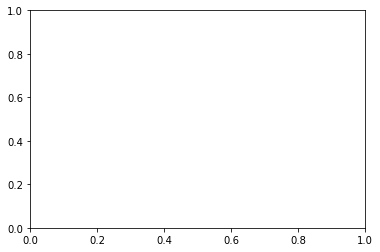

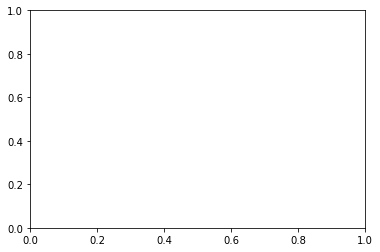

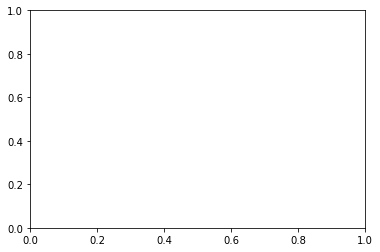

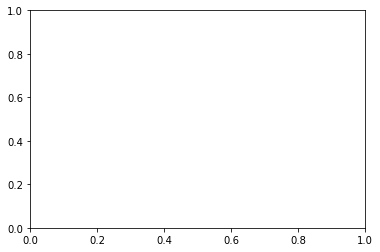

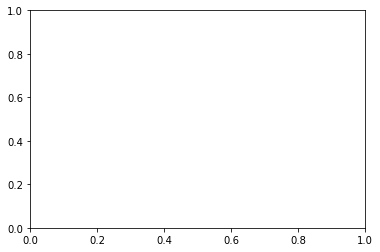

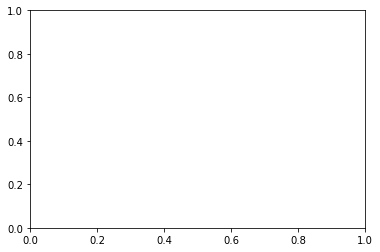

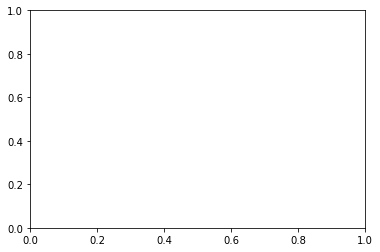

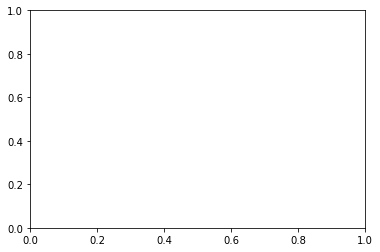

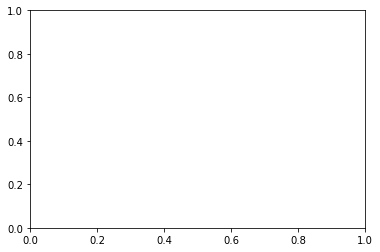

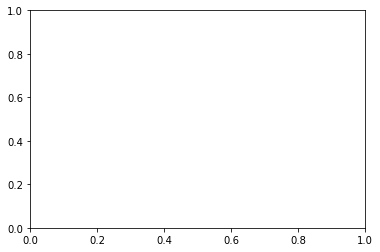

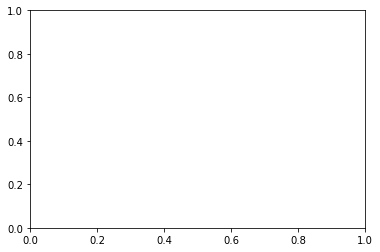

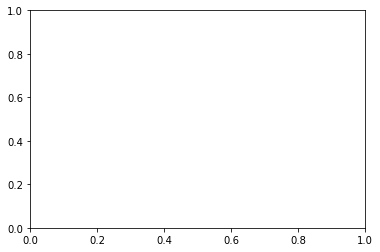

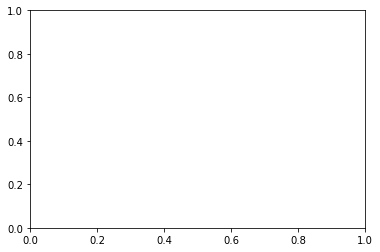

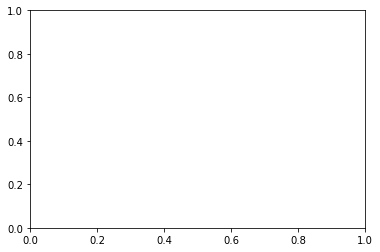

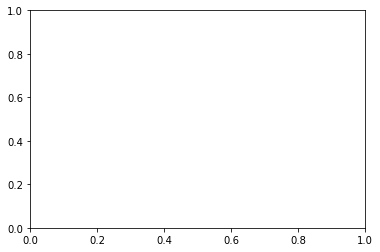

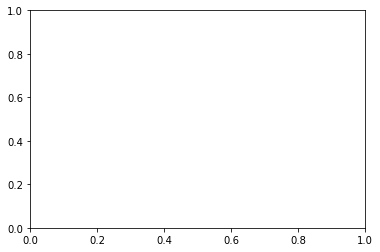

In [12]:
outputs, loss, diagnostics = run_training(vae, train_loader, test_loader, optimizer, vi, 50)